**Installing required packages and importing necessary libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
from scipy.stats import skew, norm
from lightgbm import LGBMRegressor
import plotly.express as px
from statsmodels.formula.api import ols
!pip install -q catboost
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.4 MB/s eta 0:00:00


**Reading the dataset**

In [2]:
df = pd.read_csv('/content/drive/MyDrive/data analysis/Real Estate Prices/real estate dataset.csv')
df.sample(1)

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
70389,for_sale,525000.0,3.0,2.0,0.14,"51 Upland Ave, White Plains, NY, 10604",51 Upland Ave,White Plains,New York,10604.0,1256.0,1999-12-17


**Checking for and removing duplicates**

In [3]:
print (df.shape)
df = df.drop_duplicates()
print (df.shape)

(104669, 12)
(104669, 12)


**No duplicates found**

**Checking for missing values**

In [4]:
df.isnull().sum()

status              0
price              18
bed             16416
bath            15781
acre_lot        26192
full_address        0
street            371
city               22
state               0
zip_code           31
house_size      32952
sold_date       50157
dtype: int64

**Dropping columns that are not required**

In [5]:
df = df.drop (['full_address', 'street', 'zip_code', 'sold_date'], axis =1)

**Statistical distribution**

In [6]:
df.describe()

,price,bed,bath,acre_lot,house_size
count,1.046510e+05,88253.000000,88888.000000,78477.000000,7.171700e+04
mean,8.286584e+05,3.340918,2.529127,18.564459,2.165362e+03
std,3.285961e+06,1.856217,1.740680,1007.627685,6.002088e+03
min,0.000000e+00,1.000000,1.000000,0.000000,1.000000e+02
25%,2.400000e+05,2.000000,2.000000,0.110000,1.169000e+03
50%,4.250000e+05,3.000000,2.000000,0.270000,1.674000e+03
75%,7.650000e+05,4.000000,3.000000,1.060000,2.500000e+03
max,8.750000e+08,123.000000,198.000000,100000.000000,1.450112e+06


**The above distribution shows the minimum values for price and acre lot as 0, which is not possible. Dropping these entries from the dataset**

In [7]:
df = df[df['price']!=0]
df = df[df['acre_lot']!=0]

**Checking for numerical and categorical columns**

In [8]:
num = [feature for feature in df.columns if df[feature].dtype != 'O']
cat = [feature for feature in df.columns if df[feature].dtype == 'O']

print('We have {} numerical features : {}'.format(len(num), num))
print('\nWe have {} categorical features : {}'.format(len(cat), cat))

We have 5 numerical features : ['price', 'bed', 'bath', 'acre_lot', 'house_size']

We have 3 categorical features : ['status', 'city', 'state']


**Checking for data distribution in the status column**

In [9]:
df['status'].value_counts()

for_sale          104308
ready_to_build       269
Name: status, dtype: int64

**Checking for data distribution in the city column**

In [10]:
df['city'].value_counts()

Philadelphia       5489
New York City      4453
New York           3483
Brooklyn           2656
Boston             1233
                   ... 
Knox                  1
Stannard              1
Brigantine City       1
Tinmouth              1
Erwinna               1
Name: city, Length: 2437, dtype: int64

**Unique entries are found for New York City and New York. This seems to be a mistake. Checking to see if they have the same states.**

In [11]:
df[df['city'] == 'New York']

,status,price,bed,bath,acre_lot,city,state,house_size
45710,for_sale,1185000.0,2.0,2.0,NaN,New York,New York,NaN
45729,for_sale,29995000.0,12.0,14.0,NaN,New York,New York,8528.0
46104,for_sale,895000.0,2.0,2.0,NaN,New York,New York,1425.0
46106,for_sale,985000.0,1.0,2.0,NaN,New York,New York,1166.0
46107,for_sale,810000.0,1.0,1.0,NaN,New York,New York,761.0
...,...,...,...,...,...,...,...,...
104662,for_sale,12810000.0,4.0,5.0,NaN,New York,New York,3203.0
104663,for_sale,6995000.0,3.0,4.0,NaN,New York,New York,2871.0
104664,for_sale,6800000.0,2.0,3.0,NaN,New York,New York,2502.0
104665,for_sale,769000.0,1.0,1.0,NaN,New York,New York,700.0


**Since the entry in column city with value 'New York' has the corresponding state "New York' so it confirms the above suspicion that this is a mistake. Replacing "New York" in the city column with "New York City**

In [12]:
df.replace ({"city": {'New York': 'New York City'}}, inplace = True)

**Checking to see if the problem is fixed**

In [13]:
df['city'].value_counts()

New York City      7936
Philadelphia       5489
Brooklyn           2656
Boston             1233
Staten Island      1225
                   ... 
Knox                  1
Stannard              1
Brigantine City       1
Tinmouth              1
Erwinna               1
Name: city, Length: 2436, dtype: int64

**Checking for data distribution in the state column**

In [14]:
df['state'].value_counts()

New Jersey        32236
New York          20081
Connecticut       13732
Massachusetts     10185
Pennsylvania       9053
Maine              5061
New Hampshire      3561
Rhode Island       3411
Puerto Rico        2663
Vermont            2530
Delaware           1298
Virgin Islands      750
Virginia              7
Georgia               5
Wyoming               1
South Carolina        1
West Virginia         1
Tennessee             1
Name: state, dtype: int64

**Imputing missing values in the city column**

In [15]:
imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
df[['city']] = imputer.fit_transform(df[['city']])

df.isnull().sum()

status            0
price            18
bed           16407
bath          15772
acre_lot      26190
city              0
state             0
house_size    32937
dtype: int64

**Imputing missing values in the numerical columns by median since all of them have outliers**

In [16]:
imputer1 = SimpleImputer(missing_values=np.nan, strategy="median")
df[['bed']] = imputer1.fit_transform(df[['bed']])
df[['bath']] = imputer1.fit_transform(df[['bath']])
df[['acre_lot']] = imputer1.fit_transform(df[['acre_lot']])
df[['house_size']] = imputer1.fit_transform(df[['house_size']])
df.isnull().sum()

status         0
price         18
bed            0
bath           0
acre_lot       0
city           0
state          0
house_size     0
dtype: int64

**Dropping the rows which have missing values in the target variable**

In [17]:
df = df.dropna()
df.isnull().sum()

status        0
price         0
bed           0
bath          0
acre_lot      0
city          0
state         0
house_size    0
dtype: int64

**Resetting index**

In [18]:
df = df.reset_index(drop=True)

**The columns "bath', 'bed', 'year_sold', 'month_sold' and 'day_sold' are discrete variables so converting them in to categorical data types**

**First converting them from float to int then to string type**

In [19]:
df['bath'] = df['bath'].astype('int')
df['bed'] = df['bed'].astype('int')
df['bath'] = df['bath'].astype('str')
df['bed'] = df['bed'].astype('str')

**Checking to see if the conversion was successful**

In [20]:
df.dtypes

status         object
price         float64
bed            object
bath           object
acre_lot      float64
city           object
state          object
house_size    float64
dtype: object

**Removing outliers beyond third standard deviation**

In [21]:
print (df.shape)

numerical_cols = ['price', 'acre_lot', 'house_size']

z_scores = np.abs((df[numerical_cols] - df[numerical_cols].mean()) / df[numerical_cols].std())

threshold = 3

df = df[(z_scores < threshold).all(axis=1)]

print(df.shape)

(104559, 8)
(103758, 8)


**Resetting index**

In [22]:
df = df.reset_index(drop=True)

**Checking for the numerical and categorical variables in the dataset**

In [23]:
num = [feature for feature in df.columns if df[feature].dtype != 'O']
cat = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(num), num))
print('\nWe have {} categorical features : {}'.format(len(cat), cat))

We have 3 numerical features : ['price', 'acre_lot', 'house_size']

We have 5 categorical features : ['status', 'bed', 'bath', 'city', 'state']


**Some of the categories in the categorical variables occur very infrequently. This will cause problems in the model predictions. Even if we don't remove them here, we'll have to handle them in the modular coding since it'll definitely raise the error: "Unknown categories encountered in the column " ". Removing categories in all the categorical variables that occur less than 20 times**

In [24]:
threshold = 20

for col in ['status', 'bed', 'bath', 'city', 'state']:
    counts = df[col].value_counts()
    df = df[df[col].isin(counts[counts >= threshold].index)]

**Resetting index**

In [25]:
df = df.reset_index(drop=True)

**Storing numerical, categorical and the target variables in separate variables**

In [26]:
target = df['price']
num = df[['acre_lot', 'house_size']]
cat = df[['status', 'bed', 'bath', 'city', 'state']]

In [27]:
out = num

**Plotting all the histograms (separately) in the dataset**

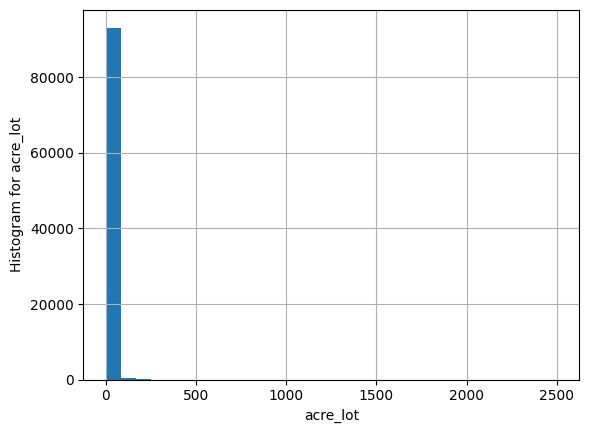

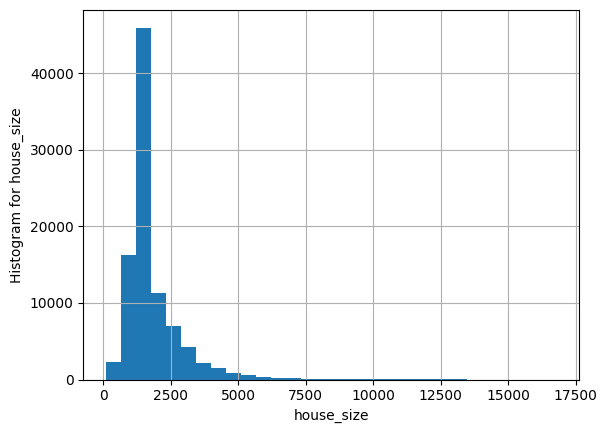

In [28]:
for i in out.columns:
    plt.figure()
    plt.hist (out[i], bins=30)
    plt.xlabel (f'{i}')
    plt.ylabel (f'Histogram for {i}')
    plt.grid()

**Plotting Q-Q plots**

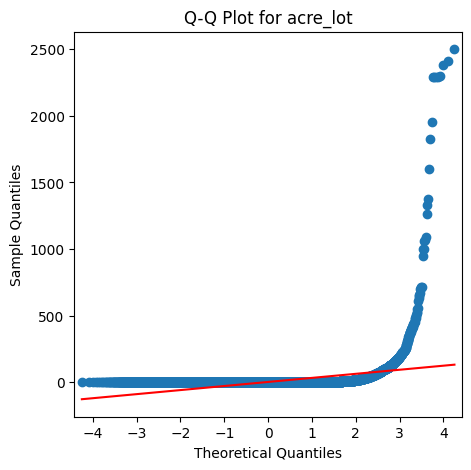

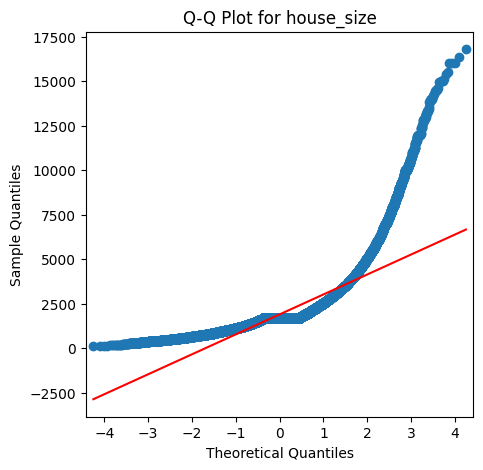

In [29]:
for i in out.columns:
  fig, ax = plt.subplots(figsize=(5,5))
  qqplot(out[i], line='s', ax=ax)
  ax.set_title(f'Q-Q Plot for {i}')
  plt.show()

**Plotting box plots**

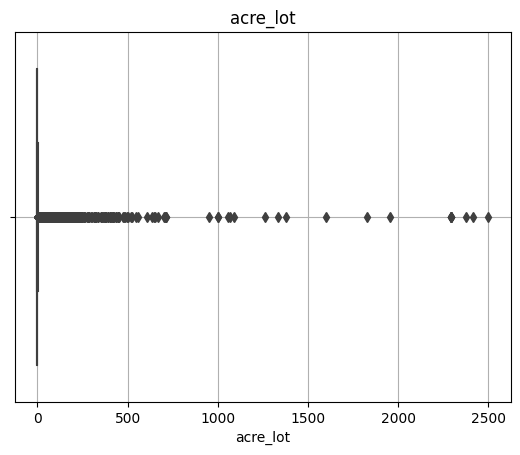

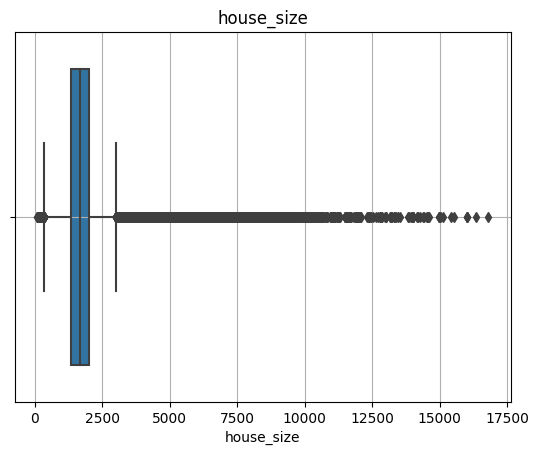

In [30]:
for col in out.columns:
    sns.boxplot(x=out[col])
    plt.title(col)
    plt.grid()
    plt.show()

**Checking for skewness and performing statistical tests to see if the data is normally distributed**

In [31]:
skewness_out = out.skew()
print("Original skewness of outliers:")
print(skewness_out)

# Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(out.sample(500).values.flatten())
print("Shapiro-Wilk Test:")
if shapiro_p > 0.05:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

# Anderson-Darling test
anderson_stat, anderson_critical_values, anderson_significance = stats.anderson(out.sample(500).values.flatten(), dist='norm')
print("\nAnderson-Darling Test:")
if anderson_stat < anderson_critical_values[2]:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

Original skewness of outliers:
acre_lot      53.199371
house_size     3.503334
dtype: float64
Shapiro-Wilk Test:
The data does not appear to be normally distributed

Anderson-Darling Test:
The data does not appear to be normally distributed


**All columns are right skewed and the data is not normally distributed**

**Applying robust scaler**

In [32]:
rs = RobustScaler()
out_rs = rs.fit_transform (out)
out_rs = pd.DataFrame (out_rs, columns = out.columns)
out_rs.head(1)

,acre_lot,house_size
0,-0.472222,0.186567


**Performing various combinations of data transformation techniques in attempt to make the data normally distributed. Also performing statistical tests after each step to check if the approach worked or not**

In [33]:
out_skewness = skew(out)
print ("Original skewness of right skewed outliers:", out_skewness)

# Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(out.sample(500).values.flatten())
print("Shapiro-Wilk Test:")
if shapiro_p > 0.05:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

# Anderson-Darling test
anderson_stat, anderson_critical_values, anderson_significance = stats.anderson(out.sample(500).values.flatten(), dist='norm')
print("Anderson-Darling Test:")
if anderson_stat < anderson_critical_values[2]:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

out_rs_skewness = skew(out_rs)
print ("\nSkewness after applying only robust scaler on right skewed outliers:", out_rs_skewness)

# Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(out_rs.sample(500).values.flatten())
print("Shapiro-Wilk Test:")
if shapiro_p > 0.05:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

# Anderson-Darling test
anderson_stat, anderson_critical_values, anderson_significance = stats.anderson(out_rs.sample(500).values.flatten(), dist='norm')
print("Anderson-Darling Test:")
if anderson_stat < anderson_critical_values[2]:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

out_exp = np.exp (out)

out_exp_skewness = skew(out_exp)
print ("\nSkewness after first applying only exponential transformation on right skewed outliers:", out_exp_skewness)

# Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(out_exp.sample(500).values.flatten())
print("Shapiro-Wilk Test:")
if shapiro_p > 0.05:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

# Anderson-Darling test
anderson_stat, anderson_critical_values, anderson_significance = stats.anderson(out_exp.sample(500).values.flatten(), dist='norm')
print("Anderson-Darling Test:")
if anderson_stat < anderson_critical_values[2]:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")


out_sqrt = np.sqrt (out)

out_sqrt_skewness = skew(out_sqrt)
print ("\nSkewness after first applying only square root transformation on right skewed outliers:", out_sqrt_skewness)

# Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(out_sqrt.sample(500).values.flatten())
print("Shapiro-Wilk Test:")
if shapiro_p > 0.05:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

# Anderson-Darling test
anderson_stat, anderson_critical_values, anderson_significance = stats.anderson(out_sqrt.sample(500).values.flatten(), dist='norm')
print("Anderson-Darling Test:")
if anderson_stat < anderson_critical_values[2]:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")


out_log = np.log (out)

out_log_skewness = skew(out_log)
print ("\nSkewness after first applying only log transformation on right skewed outliers:", out_log_skewness)

# Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(out_log.sample(500).values.flatten())
print("Shapiro-Wilk Test:")
if shapiro_p > 0.05:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

# Anderson-Darling test
anderson_stat, anderson_critical_values, anderson_significance = stats.anderson(out_log.sample(500).values.flatten(), dist='norm')
print("Anderson-Darling Test:")
if anderson_stat < anderson_critical_values[2]:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")



pt1 = PowerTransformer(method='yeo-johnson')

out_pt = pt1.fit_transform (out)
out_pt_df = pd.DataFrame (out_pt, columns = out.columns)

out_pt_df_skewness = skew(out_pt_df)
print ("\nSkewness after first applying only yeo johnson power transfomrer on right skewed outliers:", out_pt_df_skewness)

# Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(out_pt_df.sample(500).values.flatten())
print("Shapiro-Wilk Test:")
if shapiro_p > 0.05:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

# Anderson-Darling test
anderson_stat, anderson_critical_values, anderson_significance = stats.anderson(out_pt_df.sample(500).values.flatten(), dist='norm')
print("Anderson-Darling Test:")
if anderson_stat < anderson_critical_values[2]:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

out_rank = out.rank()
out_rank_skewness = skew(out_rank)
print ("\nSkewness after first applying only rank transformation on right skewed outliers:", out_rank_skewness)

# Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(out_rank.sample(500).values.flatten())
print("Shapiro-Wilk Test:")
if shapiro_p > 0.05:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

# Anderson-Darling test:
anderson_stat, anderson_critical_values, anderson_significance = stats.anderson(out_rank.sample(500).values.flatten(), dist='norm')
print("Anderson-Darling Test:")
if anderson_stat < anderson_critical_values[2]:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

Original skewness of right skewed outliers: [53.19851928  3.5032781 ]
Shapiro-Wilk Test:
The data does not appear to be normally distributed
Anderson-Darling Test:
The data does not appear to be normally distributed

Skewness after applying only robust scaler on right skewed outliers: [53.19851928  3.5032781 ]
Shapiro-Wilk Test:
The data does not appear to be normally distributed
Anderson-Darling Test:
The data does not appear to be normally distributed

Skewness after first applying only exponential transformation on right skewed outliers: [nan nan]
Shapiro-Wilk Test:
The data appears to be normally distributed
Anderson-Darling Test:
The data does not appear to be normally distributed

Skewness after first applying only square root transformation on right skewed outliers: [10.89810833  1.70071576]
Shapiro-Wilk Test:
The data does not appear to be normally distributed
Anderson-Darling Test:
The data does not appear to be normally distributed

Skewness after first applying only log tran

In [34]:
pt2 = PowerTransformer(method='yeo-johnson')

out_rs_pt = pt2.fit_transform (out_rs)
out_rs_pt_df = pd.DataFrame (out_rs_pt, columns = out_rs.columns)

out_rs_pt_df_skewness = skew(out_rs_pt_df)
print ("\nSkewness after first applying robust scaler and then yeo johnson power transfomrer on right skewed outliers:", out_rs_pt_df_skewness)

# Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(out_rs_pt_df.sample(500).values.flatten())
print("Shapiro-Wilk Test:")
if shapiro_p > 0.05:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

# Anderson-Darling test
anderson_stat, anderson_critical_values, anderson_significance = stats.anderson(out_rs_pt_df.sample(500).values.flatten(), dist='norm')
print("Anderson-Darling Test:")
if anderson_stat < anderson_critical_values[2]:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

out_rs_rank = out_rs.rank()
out_rs_rank_skewness = skew(out_rs_rank)
print ("\nSkewness after first applying robust scaler and then rank transformation on right skewed outliers:", out_rs_rank_skewness)

# Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(out_rs_rank.sample(500).values.flatten())
print("Shapiro-Wilk Test:")
if shapiro_p > 0.05:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

# Anderson-Darling test:
anderson_stat, anderson_critical_values, anderson_significance = stats.anderson(out_rs_rank.sample(500).values.flatten(), dist='norm')
print("Anderson-Darling Test:")
if anderson_stat < anderson_critical_values[2]:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")



rs1 = RobustScaler()
out_pt_rs = rs1.fit_transform(out_pt_df)
out_pt_rs_df = pd.DataFrame(out_pt_rs, columns= out.columns)

out_pt_rs_df_skewness = skew(out_pt_rs_df)
print ("\nSkewness after first applying yeo johnson power transformer and then robust scaler on right skewed outliers:", out_pt_rs_df_skewness)

# Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(out_pt_rs_df.sample(500).values.flatten())
print("Shapiro-Wilk Test:")
if shapiro_p > 0.05:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

# Anderson-Darling test
anderson_stat, anderson_critical_values, anderson_significance = stats.anderson(out_pt_rs_df.sample(500).values.flatten(), dist='norm')
print("Anderson-Darling Test:")
if anderson_stat < anderson_critical_values[2]:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")


rs2 = RobustScaler()
out_rank_rs = rs2.fit_transform(out_rank)
out_rank_rs_df = pd.DataFrame(out_rank_rs, columns= out.columns)

out_rank_rs_df_skewness = skew(out_rank_rs_df)
print ("\nSkewness after first applying rank transformation and then robust scaler on right skewed outliers:", out_rank_rs_df_skewness)

# Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(out_rank_rs_df.sample(500).values.flatten())
print("Shapiro-Wilk Test:")
if shapiro_p > 0.05:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

# Anderson-Darling test
anderson_stat, anderson_critical_values, anderson_significance = stats.anderson(out_rank_rs_df.sample(500).values.flatten(), dist='norm')
print("Anderson-Darling Test:")
if anderson_stat < anderson_critical_values[2]:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")


Skewness after first applying robust scaler and then yeo johnson power transfomrer on right skewed outliers: [ 0.28675095 -0.10706567]
Shapiro-Wilk Test:
The data does not appear to be normally distributed
Anderson-Darling Test:
The data does not appear to be normally distributed

Skewness after first applying robust scaler and then rank transformation on right skewed outliers: [-0.00447663 -0.00302485]
Shapiro-Wilk Test:
The data does not appear to be normally distributed
Anderson-Darling Test:
The data does not appear to be normally distributed

Skewness after first applying yeo johnson power transformer and then robust scaler on right skewed outliers: [ 0.73792359 -0.03762823]
Shapiro-Wilk Test:
The data does not appear to be normally distributed
Anderson-Darling Test:
The data does not appear to be normally distributed

Skewness after first applying rank transformation and then robust scaler on right skewed outliers: [-0.00447663 -0.00302485]
Shapiro-Wilk Test:
The data does not a

**Based on the above results, none of the transformations seem to have led to normally distributed data, as indicated by the Shapiro-Wilk Test and Anderson-Darling Test. Therefore, it doesn't matter if we apply any transformation technique or not.**

**Converting the data types of categorical columns from object to category type as required by the models**

In [35]:
categorical_features = ['status', 'bed', 'bath', 'city', 'state']
for feature in categorical_features:
    df[feature] = df[feature].astype('category')

**Checking if the conversion worked**

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93652 entries, 0 to 93651
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   status      93652 non-null  category
 1   price       93652 non-null  float64 
 2   bed         93652 non-null  category
 3   bath        93652 non-null  category
 4   acre_lot    93652 non-null  float64 
 5   city        93652 non-null  category
 6   state       93652 non-null  category
 7   house_size  93652 non-null  float64 
dtypes: category(5), float64(3)
memory usage: 2.7 MB


**Separating dependent and independent features and making train, test and validation splits**

In [37]:
x = df.drop ('price', axis =1)
y = df['price']
train_old, test = train_test_split (df, test_size = 0.2, random_state=1)
train, val = train_test_split (train_old, test_size = 0.2, random_state=1)

x_train = train.drop('price', axis = 1)
y_train = train['price']

x_test = test.drop('price', axis = 1)
y_test = test['price']

x_val = val.drop('price', axis = 1)
y_val = val['price']

In [38]:
x_train.head(1)

,status,bed,bath,acre_lot,city,state,house_size
26168,for_sale,2,2,0.27,Warren,Vermont,1170.0


**Xgboost model training and evaluation**

In [39]:
xg = XGBRegressor(enable_categorical=True, tree_method="hist", n_estimators=6, device='cuda')

xg.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=10)

y_pred_train = xg.predict(x_train)
y_pred_test = xg.predict(x_test)

score_train = r2_score(y_train, y_pred_train)
print("R2 score train:", score_train)

score_test = r2_score(y_test, y_pred_test)
print("R2 score test:", score_test)

MAE_train = mean_absolute_error(y_train, y_pred_train)
print('Mean Absolute Error Train:', MAE_train)

MAE_test = mean_absolute_error(y_test, y_pred_test)
print('Mean Absolute Error Test:', MAE_test)

MSE_train = mean_squared_error(y_train, y_pred_train)
print('Mean Squared Error Train:', MSE_train)

MSE_test = mean_squared_error(y_test, y_pred_test)
print('Mean Squared Error Test:', MSE_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error Train:', RMSE_train)

RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error Test:', RMSE_test)

[0]	validation_0-rmse:835822.39565
[1]	validation_0-rmse:723619.71522
[2]	validation_0-rmse:658004.47343
[3]	validation_0-rmse:618984.48240
[4]	validation_0-rmse:595700.17052
[5]	validation_0-rmse:581456.98512
R2 score train: 0.734741859560146
R2 score test: 0.6677180343030877
Mean Absolute Error Train: 270071.82660619245
Mean Absolute Error Test: 295829.97489122313
Mean Squared Error Train: 289188337281.19055
Mean Squared Error Test: 374892618659.1458
Root Mean Squared Error Train: 537762.3427511363
Root Mean Squared Error Test: 612284.7529206863


**These scores don't look promising**

**Performing grid search with various parameter combinations on xgboost**

In [40]:
param_grid = {
    'n_estimators': [4, 6, 8],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1],
    'num_leaves': [10, 20, 30]
}

xgb_hp = XGBRegressor(tree_method='hist', enable_categorical=True, device='cuda')

grid_search = GridSearchCV(
    estimator=xgb_hp,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=True,
    n_jobs=-1,
)

grid_search.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=10)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

best_xgb_model = grid_search.best_estimator_

y_pred_train = best_xgb_model.predict(x_train)
y_pred_test = best_xgb_model.predict(x_test)

score_train = r2_score(y_train, y_pred_train)
print("R2 score train:", score_train)

score_test = r2_score(y_test, y_pred_test)
print("R2 score test:", score_test)

MAE_train = mean_absolute_error(y_train, y_pred_train)
print('Mean Absolute Error Train:', MAE_train)

MAE_test = mean_absolute_error(y_test, y_pred_test)
print('Mean Absolute Error Test:', MAE_test)

MSE_train = mean_squared_error(y_train, y_pred_train)
print('Mean Squared Error Train:', MSE_train)

MSE_test = mean_squared_error(y_test, y_pred_test)
print('Mean Squared Error Test:', MSE_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error Train:', RMSE_train)

RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error Test:', RMSE_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[0]	validation_0-rmse:951504.25816
[1]	validation_0-rmse:894050.57122
[2]	validation_0-rmse:844685.78490
[3]	validation_0-rmse:801362.58316
[4]	validation_0-rmse:764519.00901
[5]	validation_0-rmse:732544.36109
[6]	validation_0-rmse:705220.66409
[7]	validation_0-rmse:682411.51865
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 8, 'num_leaves': 10}
Best Score: 507820225699.5856
R2 score train: 0.5953163949309592
R2 score test: 0.5388907305006803
Mean Absolute Error Train: 349444.16970184864
Mean Absolute Error Test: 367180.63005011744
Mean Squared Error Train: 441192035353.9907
Mean Squared Error Test: 520240275959.73773
Root Mean Squared Error Train: 664222.8807817379
Root Mean Squared Error Test: 721276.8372544191


**Seems the model's performance has deteriorated instead of improving**

**Calculating the sum of all unique categories in the categorical variables**

In [41]:
df['status'].nunique() + df['bed'].nunique() + df['bath'].nunique() + df['city'].nunique() + df['state'].nunique()

1088

In [42]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59936 entries, 26168 to 68679
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   status      59936 non-null  category
 1   bed         59936 non-null  category
 2   bath        59936 non-null  category
 3   acre_lot    59936 non-null  float64 
 4   city        59936 non-null  category
 5   state       59936 non-null  category
 6   house_size  59936 non-null  float64 
dtypes: category(5), float64(2)
memory usage: 1.8 MB


In [43]:
categorical_indices = [0, 1, 2, 4, 5]

**Training and evaluating catboost**

In [44]:
cb =  CatBoostRegressor(cat_features = categorical_indices)

cb.fit(x_train, y_train, eval_set=[(x_val, y_val)])

y_pred_train = cb.predict(x_train)
y_pred_test = cb.predict(x_test)

score_train = r2_score(y_train, y_pred_train)
print("R2 score train:", score_train)

score_test = r2_score(y_test, y_pred_test)
print("R2 score test:", score_test)

MAE_train = mean_absolute_error(y_train, y_pred_train)
print('Mean Absolute Error Train:', MAE_train)

MAE_test = mean_absolute_error(y_test, y_pred_test)
print('Mean Absolute Error Test:', MAE_test)

MSE_train = mean_squared_error(y_train, y_pred_train)
print('Mean Squared Error Train:', MSE_train)

MSE_test = mean_squared_error(y_test, y_pred_test)
print('Mean Squared Error Test:', MSE_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error Train:', RMSE_train)

RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error Test:', RMSE_test)

Learning rate set to 0.096826
0:	learn: 994022.3371512	test: 966674.2975391	best: 966674.2975391 (0)	total: 114ms	remaining: 1m 54s
1:	learn: 951286.5005314	test: 923717.6034476	best: 923717.6034476 (1)	total: 149ms	remaining: 1m 14s
2:	learn: 915052.4689253	test: 887426.0415167	best: 887426.0415167 (2)	total: 201ms	remaining: 1m 6s
3:	learn: 882450.0757894	test: 854254.7600339	best: 854254.7600339 (3)	total: 249ms	remaining: 1m 2s
4:	learn: 855929.9473823	test: 827555.6948481	best: 827555.6948481 (4)	total: 286ms	remaining: 57s
5:	learn: 828047.7300870	test: 800696.6444816	best: 800696.6444816 (5)	total: 321ms	remaining: 53.2s
6:	learn: 803260.5386534	test: 776006.4108216	best: 776006.4108216 (6)	total: 354ms	remaining: 50.2s
7:	learn: 782131.2235864	test: 754969.1610012	best: 754969.1610012 (7)	total: 384ms	remaining: 47.6s
8:	learn: 763602.8627504	test: 736529.0783968	best: 736529.0783968 (8)	total: 418ms	remaining: 46.1s
9:	learn: 747407.7569244	test: 719983.2916230	best: 719983.29

**Results are better than xgboost**

**Performing grid search with various parameter combinations on catboost**

In [45]:
param_grid = {
    'n_estimators': [400, 600, 800],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1],
    'num_leaves': [10, 20, 30]}


cb_hp = CatBoostRegressor(cat_features=categorical_indices, grow_policy='Lossguide')

grid_search = GridSearchCV(estimator=cb_hp, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=True, n_jobs=-1)

grid_search.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=10)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

best_cb_model = grid_search.best_estimator_

y_pred_train = best_cb_model.predict(x_train)
y_pred_test = best_cb_model.predict(x_test)

score_train = r2_score(y_train, y_pred_train)
print("R2 score train:", score_train)

score_test = r2_score(y_test, y_pred_test)
print("R2 score test:", score_test)

MAE_train = mean_absolute_error(y_train, y_pred_train)
print('Mean Absolute Error Train:', MAE_train)

MAE_test = mean_absolute_error(y_test, y_pred_test)
print('Mean Absolute Error Test:', MAE_test)

MSE_train = mean_squared_error(y_train, y_pred_train)
print('Mean Squared Error Train:', MSE_train)

MSE_test = mean_squared_error(y_test, y_pred_test)
print('Mean Squared Error Test:', MSE_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error Train:', RMSE_train)

RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error Test:', RMSE_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0:	learn: 992194.2803159	test: 964653.1247635	best: 964653.1247635 (0)	total: 55.4ms	remaining: 22.1s
1:	learn: 942455.6015937	test: 914512.1533703	best: 914512.1533703 (1)	total: 103ms	remaining: 20.5s
2:	learn: 899540.9098243	test: 871299.6650455	best: 871299.6650455 (2)	total: 148ms	remaining: 19.6s
3:	learn: 862281.4261058	test: 833887.8684092	best: 833887.8684092 (3)	total: 193ms	remaining: 19.1s
4:	learn: 830274.9198839	test: 801763.3134045	best: 801763.3134045 (4)	total: 238ms	remaining: 18.8s
5:	learn: 803238.0448685	test: 774707.3363500	best: 774707.3363500 (5)	total: 305ms	remaining: 20s
6:	learn: 779915.3370623	test: 751249.5770143	best: 751249.5770143 (6)	total: 348ms	remaining: 19.5s
7:	learn: 759621.4607056	test: 730507.8747610	best: 730507.8747610 (7)	total: 397ms	remaining: 19.5s
8:	learn: 740151.8696401	test: 710657.4901845	best: 710657.4901845 (8)	total: 445ms	remaining: 19.3s
9:	learn: 725166.8792059	test:

**Model's performance hasn't improved**

**Training and evaluating LGBM regressor**

In [46]:
lg = LGBMRegressor(
    categorical_column=categorical_indices,
    n_estimators=80,
    max_bins=2176,
    early_stopping_round=10
)

lg.fit(x_train, y_train, eval_set=[(x_val, y_val)], eval_metric='mse')

y_pred_train = lg.predict(x_train)
y_pred_test = lg.predict(x_test)

score_train = r2_score(y_train, y_pred_train)
print("R2 score train:", score_train)

score_test = r2_score(y_test, y_pred_test)
print("R2 score test:", score_test)

MAE_train = mean_absolute_error(y_train, y_pred_train)
print('Mean Absolute Error Train:', MAE_train)

MAE_test = mean_absolute_error(y_test, y_pred_test)
print('Mean Absolute Error Test:', MAE_test)

MSE_train = mean_squared_error(y_train, y_pred_train)
print('Mean Squared Error Train:', MSE_train)

MSE_test = mean_squared_error(y_test, y_pred_test)
print('Mean Squared Error Test:', MSE_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error Train:', RMSE_train)

RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error Test:', RMSE_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4456
[LightGBM] [Info] Number of data points in the train set: 59936, number of used features: 7
[LightGBM] [Info] Start training from score 739456.380723
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's l2: 2.73243e+11
R2 score train: 0.7806806265098545
R2 score test: 0.7220613793663246
Mean Absolute Error Train: 234284.83860243714
Mean Absolute Error Test: 258678.11036757706
Mean Squared Error Train: 239105215953.01926
Mean Squared Error Test: 313580477042.5364
Root Mean Squared Error Train: 488983.8606263189
Root Mean Squared Error Test: 559982.5685166784


**Model seems to be slightly overfitting**

**Performing grid search with various parameter combinations on lgbm regressor**

In [47]:
param_grid = {
    'n_estimators': [60, 80],
    'max_depth': [3, 5],
    'learning_rate': [0.1],
    'num_leaves': [10, 20]}

lg_hp = LGBMRegressor(categorical_column=categorical_indices, max_bins=2176, early_stopping_round=10)

grid_search = GridSearchCV(estimator=lg_hp, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=True, n_jobs=-1)

grid_search.fit(x_train, y_train, eval_set=[(x_val, y_val)])

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

best_lg_model = grid_search.best_estimator_

y_pred_train = best_lg_model.predict(x_train)
y_pred_test = best_lg_model.predict(x_test)

score_train = r2_score(y_train, y_pred_train)
print("R2 score train:", score_train)

score_test = r2_score(y_test, y_pred_test)
print("R2 score test:", score_test)

MAE_train = mean_absolute_error(y_train, y_pred_train)
print('Mean Absolute Error Train:', MAE_train)

MAE_test = mean_absolute_error(y_test, y_pred_test)
print('Mean Absolute Error Test:', MAE_test)

MSE_train = mean_squared_error(y_train, y_pred_train)
print('Mean Squared Error Train:', MSE_train)

MSE_test = mean_squared_error(y_test, y_pred_test)
print('Mean Squared Error Test:', MSE_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error Train:', RMSE_train)

RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error Test:', RMSE_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4456
[LightGBM] [Info] Number of data points in the train set: 59936, number of used features: 7
[LightGBM] [Info] Start training from score 739456.380723
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

**Overfitting issue has disappeared now**

**Calculating feature importance scores from the trained model**

In [48]:
feature_importances_lg = best_lg_model.feature_importances_

importance_df_lg = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances_lg*100})

importance_df_lg = importance_df_lg.sort_values(by='Importance', ascending=False)

importance_df_lg['imp'] = ((importance_df_lg['Importance']/importance_df_lg['Importance'].sum())*100)
importance_df_lg

,Feature,Importance,imp
6,house_size,42700,28.372093
4,city,41600,27.641196
3,acre_lot,32600,21.661130
2,bath,17200,11.428571
1,bed,8100,5.382060
5,state,7900,5.249169
0,status,400,0.265781


**The above results show that the variable status is almost irrelevant. Dropping it from the dataset and separating independent and dependent features**

In [49]:
df = df.drop(['status'], axis=1)

x = df.drop ('price', axis =1)
y = df['price']

**Making train, test and validation splits**

In [50]:
train_old, test = train_test_split (df, test_size = 0.2, random_state=1)
train, val = train_test_split (train_old, test_size = 0.2, random_state=1)

x_train = train.drop('price', axis = 1)
y_train = train['price']

x_test = test.drop('price', axis = 1)
y_test = test['price']

x_val = val.drop('price', axis = 1)
y_val = val['price']

In [51]:
categorical_indices = [0, 1, 3, 4]

**Training and evaluating the model again**

In [52]:
lg2 = LGBMRegressor(
    categorical_column=categorical_indices,
    n_estimators=80,
    max_bins=2176,
    early_stopping_round=10,
    learning_rate = 0.1,
    max_depth = 5,
    num_leaves = 20)

lg2.fit(x_train, y_train, eval_set=[(x_val, y_val)], eval_metric='mse')

y_pred_train = lg2.predict(x_train)
y_pred_test = lg2.predict(x_test)

score_train = r2_score(y_train, y_pred_train)
print("R2 score train:", score_train)

score_test = r2_score(y_test, y_pred_test)
print("R2 score test:", score_test)

MAE_train = mean_absolute_error(y_train, y_pred_train)
print('Mean Absolute Error Train:', MAE_train)

MAE_test = mean_absolute_error(y_test, y_pred_test)
print('Mean Absolute Error Test:', MAE_test)

MSE_train = mean_squared_error(y_train, y_pred_train)
print('Mean Squared Error Train:', MSE_train)

MSE_test = mean_squared_error(y_test, y_pred_test)
print('Mean Squared Error Test:', MSE_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error Train:', RMSE_train)

RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error Test:', RMSE_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4454
[LightGBM] [Info] Number of data points in the train set: 59936, number of used features: 6
[LightGBM] [Info] Start training from score 739456.380723
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[80]	valid_0's l2: 2.85318e+11


**The results indicate a difference in the model evaluation scores by decimals. This confirms that the status columns was indeed irrelevant for the model**

**Calculating feature importance scores from the trained model again**

In [53]:
feature_importances = lg2.feature_importances_

importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances*100})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df['imp'] = ((importance_df['Importance']/importance_df['Importance'].sum())*100)
importance_df

,Feature,Importance,imp
5,house_size,42900,28.354263
3,city,42200,27.891606
2,acre_lot,32400,21.414408
1,bath,18000,11.896894
0,bed,8400,5.551884
4,state,7400,4.890945


In [54]:
imp = importance_df['Feature'].values
imp

array(['house_size', 'city', 'acre_lot', 'bath', 'bed', 'state'],
      dtype=object)

**Separating numerical and categorical variables from x_train, x_test and x_validation and applying robust scaler on the numerical columns to see if it can improve the model's performance**

In [55]:
x_train_num = x_train[['acre_lot', 'house_size']]
x_val_num = x_val[['acre_lot', 'house_size']]
x_test_num = x_test[['acre_lot', 'house_size']]

x_train_num = x_train_num.reset_index(drop=True)
x_test_num = x_test_num.reset_index(drop=True)
x_val_num = x_val_num.reset_index(drop=True)

x_train_cat = x_train[['bed', 'bath', 'city', 'state']]
x_val_cat = x_val[['bed', 'bath', 'city', 'state']]
x_test_cat = x_test[['bed', 'bath', 'city', 'state']]

x_train_cat = x_train_cat.reset_index(drop=True)
x_test_cat = x_test_cat.reset_index(drop=True)
x_val_cat = x_val_cat.reset_index(drop=True)

rs = RobustScaler()
x_train_num_rs = rs.fit_transform(x_train_num)
x_val_num_rs = rs.transform(x_val_num)
x_test_num_rs = rs.transform(x_test_num)

x_train_num_rs_df = pd.DataFrame(x_train_num_rs, columns = ['acre_lot', 'house_size'])
x_test_num_rs_df = pd.DataFrame(x_test_num_rs, columns = ['acre_lot', 'house_size'])
x_val_num_rs_df = pd.DataFrame(x_val_num_rs, columns = ['acre_lot', 'house_size'])

x_train_num_rs_df = x_train_num_rs_df.reset_index(drop=True)
x_test_num_rs_df = x_test_num_rs_df.reset_index(drop=True)
x_val_num_rs_df = x_val_num_rs_df.reset_index(drop=True)

x_train_rs = pd.concat([x_train_num_rs_df, x_train_cat], axis=1)
x_val_rs = pd.concat([x_val_num_rs_df, x_val_cat], axis=1)
x_test_rs = pd.concat([x_test_num_rs_df, x_test_cat], axis=1)


x_train_rs = x_train_rs.reset_index(drop=True)
x_test_rs = x_test_rs.reset_index(drop=True)
x_val_rs = x_val_rs.reset_index(drop=True)

**Training and evaluating lgbm regressor after applying robust scaler**

In [56]:
lg3 = LGBMRegressor(
    categorical_column=[2,3,4,5],
    n_estimators=80,
    max_bins=2176,
    early_stopping_round=10,
    learning_rate = 0.1,
    max_depth = 5,
    num_leaves = 20)

lg3.fit(x_train_rs, y_train, eval_set=[(x_val_rs, y_val)], eval_metric='mse')

y_pred_train = lg3.predict(x_train_rs)
y_pred_test = lg3.predict(x_test_rs)

score_train = r2_score(y_train, y_pred_train)
print("R2 score train:", score_train)

score_test = r2_score(y_test, y_pred_test)
print("R2 score test:", score_test)

MAE_train = mean_absolute_error(y_train, y_pred_train)
print('Mean Absolute Error Train:', MAE_train)

MAE_test = mean_absolute_error(y_test, y_pred_test)
print('Mean Absolute Error Test:', MAE_test)

MSE_train = mean_squared_error(y_train, y_pred_train)
print('Mean Squared Error Train:', MSE_train)

MSE_test = mean_squared_error(y_test, y_pred_test)
print('Mean Squared Error Test:', MSE_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error Train:', RMSE_train)

RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error Test:', RMSE_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4453
[LightGBM] [Info] Number of data points in the train set: 59936, number of used features: 6
[LightGBM] [Info] Start training from score 739456.380723
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

**Model's performance didn't improve. There's no need to proceed with this approach since it will only change the original data and make it difficult to interpret the results of data anlaysis.**

**Univariate Data Analysis**

<Axes: xlabel='Top 5 Cities', ylabel='Count'>

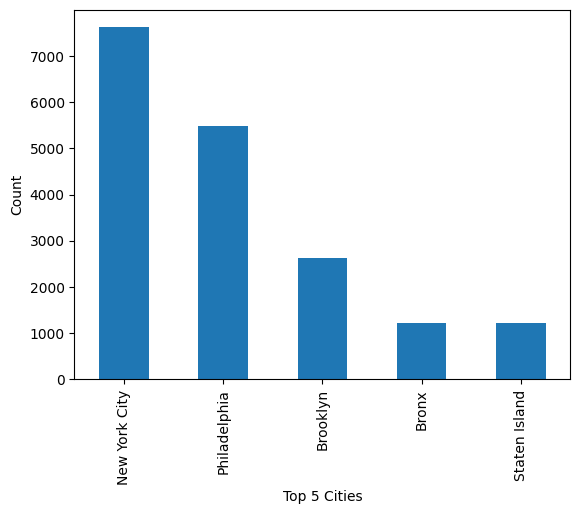

In [57]:
df['city'].value_counts().sort_values(ascending=False).head(5).plot(kind='bar', xlabel ='Top 5 Cities', ylabel = 'Count')

**The bar plot above shows that the top 5 cities with the most houses are New York City, Philadelphia, Brooklyn, Bronx and Staten Island**

<Axes: ylabel='Frequency'>

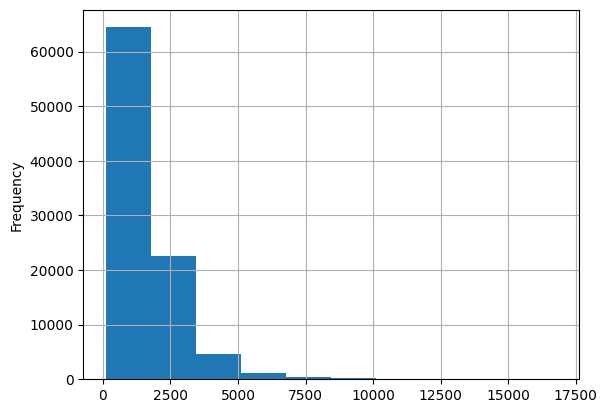

In [58]:
df['house_size'].plot(kind='hist', grid=True)

**The histogram above shows that the most of the values for house size are between 0-2500**

<Axes: ylabel='Frequency'>

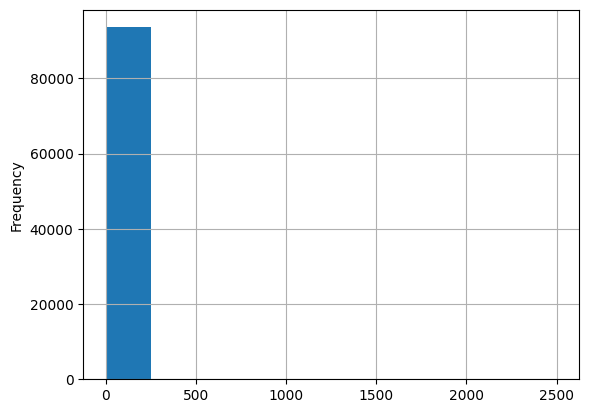

In [59]:
df['acre_lot'].plot(kind='hist',grid=True)

**The histogram above shows that the most of the values for acre lot are between 0-250**

<Axes: xlabel='Top Five Values For Number Of Baths', ylabel='Count'>

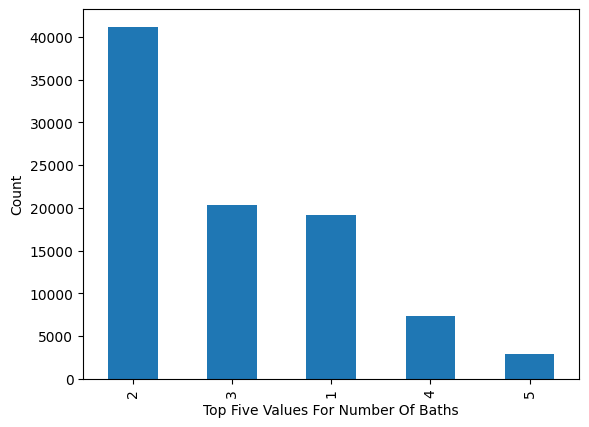

In [60]:
df['bath'].value_counts().sort_values(ascending=False).head(5).plot(kind='bar', xlabel ='Top Five Values For Number Of Baths', ylabel = 'Count')

**The bar plot indicates a predominant number of houses in the dataset with 2 baths, followed by 3, 1, 4, and 5 baths, in descending order of frequency.**

<Axes: xlabel='Top five values for number of beds', ylabel='Count'>

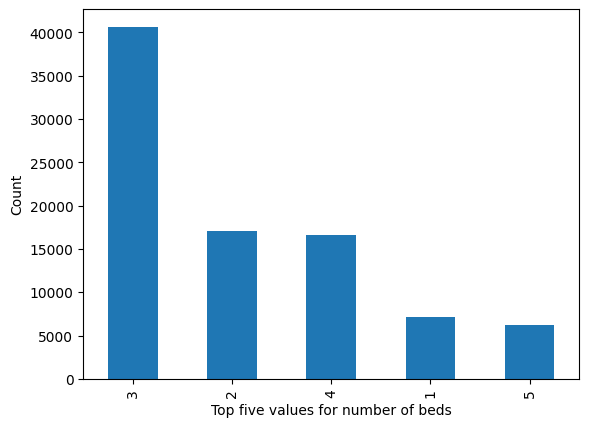

In [61]:
df['bed'].value_counts().sort_values(ascending=False).head(5).plot(kind='bar', xlabel ='Top five values for number of beds', ylabel = 'Count')

**The bar plot indicates a predominant number of houses in the dataset with 3 beds, followed by 2, 4, 1, and 5 beds, in descending order of frequency.**

<Axes: xlabel='Top 5 States', ylabel='Count'>

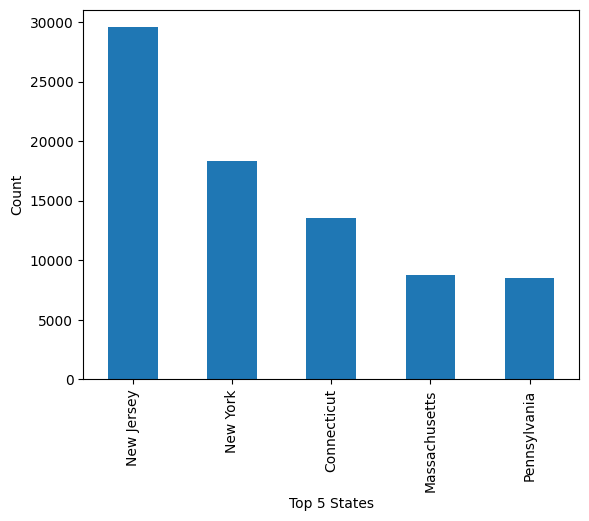

In [62]:
df['state'].value_counts().sort_values(ascending=False).head(5).plot(kind='bar', xlabel ='Top 5 States', ylabel = 'Count')

**The bar plot above shows that the top 5 states with the most houses are New Jersey, New York, Connecticut, Massachusetts, & Pennsylvania**

In [63]:
target = df['price']
num = df[['acre_lot', 'house_size']]
cat = df[['bed', 'bath', 'city', 'state']]

**Performing separate statistical tests to find the relationship between independent and dependent features**

**Checking for unique categories in the categorical variables for choosing the appropriate statistical test**

In [64]:
for i in cat.columns:
    print ("Unique values in {}".format(i))
    print (cat[i].nunique())

Unique values in bed
14
Unique values in bath
13
Unique values in city
1047
Unique values in state
12


**All categorical variables have more than two categories so one way anova would be the best choice in order to find the relationship between the independent categorical features and dependent continuous feature.**

**Proceeding with one way anova and storing the results in a separate dataframe.**

In [65]:
categorical_columns = ['bed', 'bath', 'city', 'state']

alpha = 0.05

results_list = []

for cat_col in categorical_columns:
    formula = f'price ~ {cat_col}'
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    p_value = anova_table.loc[cat_col, 'PR(>F)']

    if p_value < alpha:
        results_list.append({'Categorical Variable': cat_col,
                             'Target Variable': 'price',
                             'P-Value': p_value})

    if p_value < alpha:
        print(f"Significant relationship between {cat_col} and price.")
    else:
        print(f"No significant relationship between {cat_col} and price.")

results_df = pd.DataFrame(results_list)
print(results_df)

Significant relationship between bed and price.
Significant relationship between bath and price.
Significant relationship between city and price.
Significant relationship between state and price.
  Categorical Variable Target Variable  P-Value
0                  bed           price      0.0
1                 bath           price      0.0
2                 city           price      0.0
3                state           price      0.0


**The results indicate a very strong relationship between the independent features and the dependent continuous feature since all the p-values are 0.**

**Performing the pearson correlation test to find the relationship between independent continuous features and the dependent continuous feature.**

In [66]:
all_num = df[['price', 'acre_lot', 'house_size']]
cor = all_num.corr()
dep_var = ['price']
cor[dep_var].iloc[1:].sort_values(by = 'price', ascending=False)

,price
house_size,0.410892
acre_lot,0.033536


**The above results show that there is a reasonable relationship between house size and price (but not very strong). However, there's not a significant relationship between acre lot and house size.**

**The results of statistical tests paint a different picture than what we derive from the feature importance scores. Statistical tests provide a more direct and rigorous assessment of the relationship between independent and dependent variables so relying on them and not the feature importance scores from the model.**

**Bivariate Analysis**

**Statistical tests revealed that the relationship between independent categorical features and the dependent variable was way stronger than that with the continuous independent feature and the target variable so giving them a priority. Also after performing the statistical tests between independent categorical features and the dependent variable, all the p-values were 0 indicating a very strong relationship, so it doesn't matter which categorical variable we start with.**

**Starting bivariate analysis between house price and number of beds. Making pivot table**

In [67]:
pt_price_with_bed = df.pivot_table(index = 'bed', values = ['price'], aggfunc='median')
pt_price_with_bed.sort_values(by ='price', ascending=False).head()

,price
bed,
14,1449000.0
11,1350000.0
12,1195000.0
13,899000.0
7,879000.0


<Axes: xlabel='Number Of Beds', ylabel='Prices'>

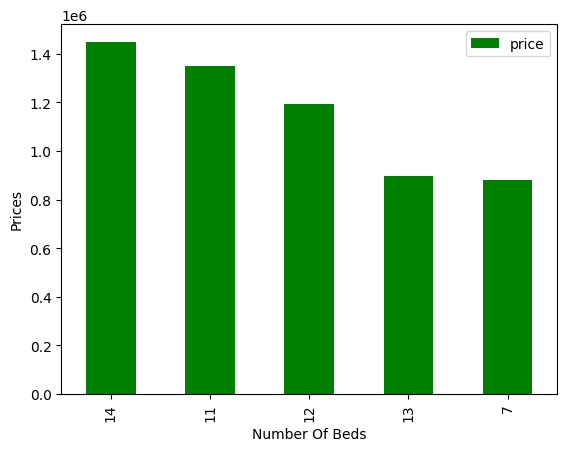

In [68]:
pt_price_with_bed.sort_values(by = 'price', ascending=False).head(5).plot(kind='bar', xlabel = 'Number Of Beds', ylabel = 'Prices', color = 'green')

**The bar plots illustrate a clear trend: properties with a greater number of beds tend to command higher prices. Notably, the highest property prices are associated with 14 beds (price: 1449000), followed by 11 beds (price: 1350000), 12 beds (price: 1195000), 13 beds (price: 899000), and 7 beds (price: 879000). This pattern aligns with the intuitive expectation that a higher number of beds often correlates with a larger property size, justifying the observed increase in real estate prices.**

**Running sensitivity analysis**

**Making train, test, validation splits for sensitivity analysis**

In [69]:
train_old_for_sa, test_for_sa = train_test_split (df, test_size = 0.2, random_state=1)
train_for_sa, val_for_sa = train_test_split (train_old_for_sa, test_size = 0.2, random_state=1)

x_train_for_sa = train_for_sa.drop('price', axis = 1)
y_train_for_sa = train_for_sa['price']

x_test_for_sa = test_for_sa.drop('price', axis = 1)
y_test_for_sa = test_for_sa['price']

x_val_for_sa = val_for_sa.drop('price', axis = 1)
y_val_for_sa = val_for_sa['price']

In [70]:
lg4 = LGBMRegressor(categorical_column=categorical_indices, n_estimators=80, max_bins=2176, early_stopping_round=10,
                    learning_rate = 0.1, max_depth = 5, num_leaves = 20)

lg4.fit(x_train_for_sa, y_train_for_sa, eval_set=[(x_val_for_sa, y_val_for_sa)], eval_metric='mse')

scenarios = [0, 25, 50, 75, 100]

for scenario in scenarios:
    modified_x_test_for_sa = x_test_for_sa.copy()
    num = int(len(modified_x_test_for_sa) * (scenario / 100))

    indices_to_change = np.random.choice(
        modified_x_test_for_sa.index[modified_x_test_for_sa['bed'] == '3'],
        num,
        replace=True)

    modified_x_test_for_sa.loc[indices_to_change, 'bed'] = '14'

    y_pred_test_for_sa = lg4.predict(modified_x_test_for_sa)

    score_test_for_sa = r2_score(y_test_for_sa, y_pred_test_for_sa)

    mae_test_for_sa = mean_absolute_error(y_test_for_sa, y_pred_test_for_sa)

    mse_test_for_sa = mean_squared_error(y_test_for_sa, y_pred_test_for_sa)

    rmse_test_for_sa = np.sqrt(mean_squared_error(y_test_for_sa, y_pred_test_for_sa))

    print(f"Scenario: With {scenario}% Changes In Number Of Beds From 3 to 14")
    print ("R2 Score:")
    print (score_test_for_sa)
    print("Mean Absolute Error:")
    print(mae_test_for_sa)
    print ("Mean Squared Error:")
    print (mse_test_for_sa)
    print ("Root Mean Squared Error:")
    print (rmse_test_for_sa)
    print("=" * 50)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4454
[LightGBM] [Info] Number of data points in the train set: 59936, number of used features: 6
[LightGBM] [Info] Start training from score 739456.380723
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[80]	valid_0's l2: 2.85318e+11
Scenario: With 0% Changes In Number Of Beds From 3 to 14
R2 Scor

**While the statistical tests indicate significance, the observed changes in model performance metrics (R2 scores and error metrics) with variations in the number of beds are relatively small. The model's response to changes in the number of beds may be influenced by other variables not explicitly considered in the presented scenarios.
Also, when we look at the data distribution in the origibal column, we find that there are very less samples of points for the value 14 whereas there is a large proportion of properties with 3 beds (40668). In scenarios where one category dominates the dataset, the model might place more emphasis on that particular category, and changes in less frequent categories might have a smaller impact on overall model performance.**

**Bivariate analysis between house price and number of baths. Making the pivot table**

In [71]:
pt_price_with_bath = df.pivot_table(index = 'bath', values = ['price'], aggfunc='median')
pt_price_with_bath.sort_values(by ='price', ascending=False).head()

,price
bath,
11,5900000.0
13,5700000.0
12,5500000.0
10,4795000.0
9,3988000.0


<Axes: xlabel='Number Of Baths', ylabel='Prices'>

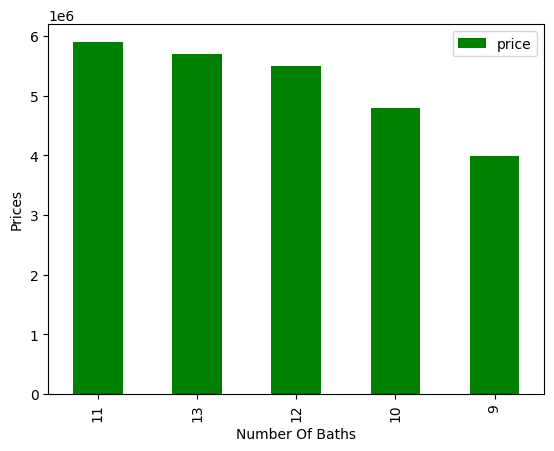

In [72]:
pt_price_with_bath.sort_values(by = 'price', ascending=False).head(5).plot(kind='bar', xlabel = 'Number Of Baths', ylabel = 'Prices', color = 'green')

**The bar plots illustrate a clear trend: properties with a greater number of baths tend to command higher prices. Notably, the highest property prices are associated with 11 baths (price: 5900000), followed by 13 baths (price: 5700000), 12 baths (price: 5500000), 10 baths (price: 4795000), and 9 beds (price: 3988000). This pattern aligns with the intuitive expectation that a higher number of baths often correlates with a larger property size, justifying the observed increase in real estate prices.**

**Running sensitivity analysis**

In [73]:
lg5 = LGBMRegressor(categorical_column=categorical_indices, n_estimators=80, max_bins=2176, early_stopping_round=10,
                    learning_rate = 0.1, max_depth = 5, num_leaves = 20)

lg5.fit(x_train_for_sa, y_train_for_sa, eval_set=[(x_val_for_sa, y_val_for_sa)], eval_metric='mse')

scenarios = [0, 25, 50, 75, 100]

for scenario in scenarios:
    modified_x_test_for_sa = x_test_for_sa.copy()
    num = int(len(modified_x_test_for_sa) * (scenario / 100))

    indices_to_change = np.random.choice(
        modified_x_test_for_sa.index[modified_x_test_for_sa['bath'] == '2'],
        num,
        replace=True)

    modified_x_test_for_sa.loc[indices_to_change, 'bath'] = '11'

    y_pred_test_for_sa = lg5.predict(modified_x_test_for_sa)

    score_test_for_sa = r2_score(y_test_for_sa, y_pred_test_for_sa)

    mae_test_for_sa = mean_absolute_error(y_test_for_sa, y_pred_test_for_sa)

    mse_test_for_sa = mean_squared_error(y_test_for_sa, y_pred_test_for_sa)

    rmse_test_for_sa = np.sqrt(mean_squared_error(y_test_for_sa, y_pred_test_for_sa))

    print(f"Scenario: With {scenario}% Changes In Number Of Baths From 2 to 11")
    print ("R2 Score:")
    print (score_test_for_sa)
    print("Mean Absolute Error:")
    print(mae_test_for_sa)
    print ("Mean Squared Error:")
    print (mse_test_for_sa)
    print ("Root Mean Squared Error:")
    print (rmse_test_for_sa)
    print("=" * 50)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4454
[LightGBM] [Info] Number of data points in the train set: 59936, number of used features: 6
[LightGBM] [Info] Start training from score 739456.380723
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[80]	valid_0's l2: 2.85318e+11


**The results of sensitivity analysis show a drastic change with the change in number of baths from 2 to 11. This confirms the above finding that number of baths is in fact a determining factor in real esate prices and that as the number of baths increase, the real estate price increases.**

**Bivariate analysis between house prices and cities. Making the pivot table**

In [74]:
pt_price_with_city = df.pivot_table(index = 'city', values = ['price'], aggfunc='median')
pt_price_with_city.sort_values(by ='price', ascending=False).head()

,price
city,
Alpine,4443500.0
Nantucket,3695000.0
Spring Lake,3690000.0
Stone Harbor,3495000.0
Saddle River,3200000.0


<Axes: xlabel='Top 5 Cities', ylabel='Prices'>

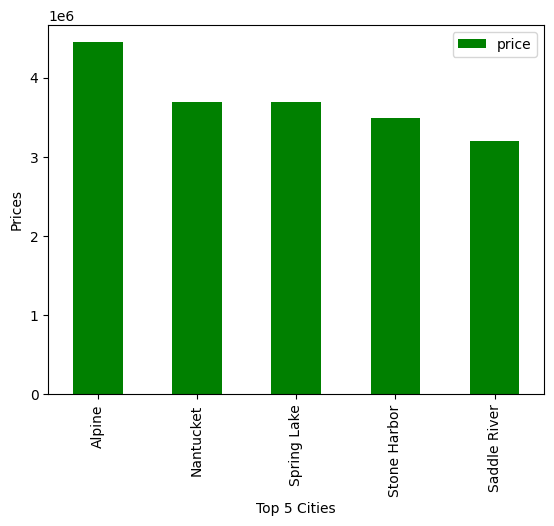

In [75]:
pt_price_with_city.sort_values(by = 'price', ascending=False).head(5).plot(kind='bar', xlabel = 'Top 5 Cities', ylabel = 'Prices', color = 'green')

**The bar plots illustrate that the city with the highest real estate price is Alpine (price: 4443500), followed by Nantucket (price: 3695000), Spring Lake (price: 3690000), Stone Harbor (price: 3495000) and Saddle River (price: 3200000). This is understandable since they are often associated with wealth, luxury real estate, and upscale communities.**

**Sensitivity Analysis**

In [76]:
lg6 = LGBMRegressor(categorical_column=categorical_indices, n_estimators=80, max_bins=2176, early_stopping_round=10,
                    learning_rate = 0.1, max_depth = 5, num_leaves = 20)

lg6.fit(x_train_for_sa, y_train_for_sa, eval_set=[(x_val_for_sa, y_val_for_sa)], eval_metric='mse')

scenarios = [0, 25, 50, 75, 100]

for scenario in scenarios:
    modified_x_test_for_sa = x_test_for_sa.copy()
    num = int(len(modified_x_test_for_sa) * (scenario / 100))

    indices_to_change = np.random.choice(
        modified_x_test_for_sa.index[modified_x_test_for_sa['city'] == 'Philadelphia'],
        num,
        replace=True)

    modified_x_test_for_sa.loc[indices_to_change, 'city'] = 'Alpine'

    y_pred_test_for_sa = lg6.predict(modified_x_test_for_sa)

    score_test_for_sa = r2_score(y_test_for_sa, y_pred_test_for_sa)

    mae_test_for_sa = mean_absolute_error(y_test_for_sa, y_pred_test_for_sa)

    mse_test_for_sa = mean_squared_error(y_test_for_sa, y_pred_test_for_sa)

    rmse_test_for_sa = np.sqrt(mean_squared_error(y_test_for_sa, y_pred_test_for_sa))

    print(f"Scenario: With {scenario}% Changes In City From Philadelphia to Alpine")
    print ("R2 Score:")
    print (score_test_for_sa)
    print("Mean Absolute Error:")
    print(mae_test_for_sa)
    print ("Mean Squared Error:")
    print (mse_test_for_sa)
    print ("Root Mean Squared Error:")
    print (rmse_test_for_sa)
    print("=" * 50)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4454
[LightGBM] [Info] Number of data points in the train set: 59936, number of used features: 6
[LightGBM] [Info] Start training from score 739456.380723
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[80]	valid_0's l2: 2.85318e+11
Scenario: With 0% Changes In City From Philadelphia to Alpine
R2

**The results of sensitivity analysis show a reasonable change with the change in city from Philly to Alpine. This confirms the above finding that city is in fact a determining factor in real estate prices.**

**Bivariate analysis between house prices and states. Making the pivot table**

In [77]:
pt_price_with_state = df.pivot_table(index = 'state', values = ['price'], aggfunc='median')
pt_price_with_state.sort_values(by ='price', ascending=False).head(5)

,price
state,
New York,799000.0
Massachusetts,589450.0
New Jersey,425000.0
Rhode Island,391450.0
New Hampshire,349000.0


<Axes: xlabel='Top 5 States', ylabel='Prices'>

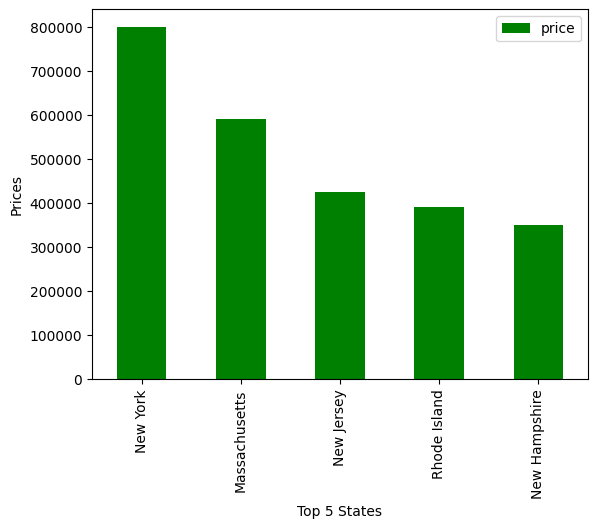

In [78]:
pt_price_with_state.sort_values(by = 'price', ascending=False).head(5).plot(kind='bar', xlabel = 'Top 5 States', ylabel = 'Prices', color = 'green')

In [79]:
pt_price_with_state.sort_values(by ='price', ascending=False).head(5)

,price
state,
New York,799000.0
Massachusetts,589450.0
New Jersey,425000.0
Rhode Island,391450.0
New Hampshire,349000.0


**The bar plots illustrate that the state with the highest real estate price is New York (price: 799000), followed by Massachusetts (price: 589450), New Jersey (price: 425000), Rhode Island (price: 391450) and New Hampshire (price: 349000). This is again understandable since these are some of the major states, and are known for their economic significance, cultural contributions, and historical importance.**

**Sensitivity Analysis**

In [80]:
lg7 = LGBMRegressor(categorical_column=categorical_indices, n_estimators=80, max_bins=2176, early_stopping_round=10,
                    learning_rate = 0.1, max_depth = 5, num_leaves = 20)

lg7.fit(x_train_for_sa, y_train_for_sa, eval_set=[(x_val_for_sa, y_val_for_sa)], eval_metric='mse')

scenarios = [0, 25, 50, 75, 100]

for scenario in scenarios:
    modified_x_test_for_sa = x_test_for_sa.copy()
    num = int(len(modified_x_test_for_sa) * (scenario / 100))

    indices_to_change = np.random.choice(
        modified_x_test_for_sa.index[modified_x_test_for_sa['state'] == 'Connecticut'],
        num,
        replace=True)

    modified_x_test_for_sa.loc[indices_to_change, 'state'] = 'New York'

    y_pred_test_for_sa = lg7.predict(modified_x_test_for_sa)

    score_test_for_sa = r2_score(y_test_for_sa, y_pred_test_for_sa)

    mae_test_for_sa = mean_absolute_error(y_test_for_sa, y_pred_test_for_sa)

    mse_test_for_sa = mean_squared_error(y_test_for_sa, y_pred_test_for_sa)

    rmse_test_for_sa = np.sqrt(mean_squared_error(y_test_for_sa, y_pred_test_for_sa))

    print(f"Scenario: With {scenario}% Changes In State From Connecticut to New York")
    print ("R2 Score:")
    print (score_test_for_sa)
    print("Mean Absolute Error:")
    print(mae_test_for_sa)
    print ("Mean Squared Error:")
    print (mse_test_for_sa)
    print ("Root Mean Squared Error:")
    print (rmse_test_for_sa)
    print("=" * 50)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4454
[LightGBM] [Info] Number of data points in the train set: 59936, number of used features: 6
[LightGBM] [Info] Start training from score 739456.380723
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[80]	valid_0's l2: 2.85318e+11


**The results of sensitivity analysis are similar to what we observed earlier. While the statistical tests indicate significance, the observed changes in model performance metrics (R2 scores and error metrics) with variations in the state are relatively small. The model's response to changes in state may be influenced by other variables not explicitly considered in the presented scenarios. Also, when we look at the feature importance values, this feature was considered to be the least important by the model.**

**Bivariate analysis between house prices and house size. Making the pivot table**

In [81]:
pt_price_with_house_size = df.pivot_table(index = 'house_size', values = ['price'], aggfunc='median')
pt_price_with_house_size.sort_values(by ='price',ascending=False)

,price
house_size,
11923.0,10600000.0
11078.0,10500000.0
11902.0,10488000.0
4835.0,10250000.0
11242.0,10000000.0
...,...
6390.0,43900.0
100.0,35000.0
401.0,29450.0


In [82]:
fig = px.scatter(x=pt_price_with_house_size.index,
    y=pt_price_with_house_size['price'],
    title='Price With House Size',
    labels={ 'x': 'House Size', 'y': 'Price'},
    trendline='ols',
    trendline_color_override='red'
)
fig.show()

**The above scatter plot shows that as the house size increases, so does the price. This is intuitive and understandable since it is a general understanding that the price increases with the property size.**

In [83]:
df['house_size'].describe()

count    93652.000000
mean      1899.959275
std       1121.775461
min        100.000000
25%       1350.000000
50%       1675.000000
75%       2020.000000
max      16800.000000
Name: house_size, dtype: float64

**Sensitivity Analysis**

In [84]:
lg8 = LGBMRegressor(categorical_column=categorical_indices, n_estimators=80, max_bins=2176, early_stopping_round=10,
                    learning_rate = 0.1, max_depth = 5, num_leaves = 20)

lg8.fit(x_train_for_sa, y_train_for_sa, eval_set=[(x_val_for_sa, y_val_for_sa)], eval_metric='mse')

scenarios = [0, 25, 50, 75, 100]

for scenario in scenarios:
    modified_x_test_for_sa = x_test_for_sa.copy()
    num = int(len(modified_x_test_for_sa) * (scenario / 100))

    indices_to_change = np.random.choice(
       modified_x_test_for_sa.index[(modified_x_test_for_sa['house_size'] >= 100) & (modified_x_test_for_sa['house_size'] <= 1674)],
       num, replace=True)

    modified_x_test_for_sa.loc[indices_to_change, 'house_size'] = 11923

    y_pred_test_for_sa = lg8.predict(modified_x_test_for_sa)

    score_test_for_sa = r2_score(y_test_for_sa, y_pred_test_for_sa)
    MAE_test_for_sa = mean_absolute_error(y_test_for_sa, y_pred_test_for_sa)
    MSE_test_for_sa = mean_squared_error(y_test_for_sa, y_pred_test_for_sa)
    RMSE_test_for_sa = np.sqrt(mean_squared_error(y_test_for_sa, y_pred_test_for_sa))

    print(f"Scenario: With {scenario}% Changes In (min-50%) Values Of House Size to 11923:")
    print(f"R2 score:", score_test_for_sa)
    print(f"Mean Absolute Error:", MAE_test_for_sa)
    print(f"Mean Squared Error:", MSE_test_for_sa)
    print(f"Root Mean Squared Error:", RMSE_test_for_sa)
    print("=" * 50)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4454
[LightGBM] [Info] Number of data points in the train set: 59936, number of used features: 6
[LightGBM] [Info] Start training from score 739456.380723
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[80]	valid_0's l2: 2.85318e+11


**The results of sensitivity analysis show a drastic change with the change in house size. This confirms the above finding that house size is in fact a determining factor is real esate prices and that as the house size increases, the real estate price increases.**

**Last words**

Conclusions:

1.   There is a positive correlation between price and the number of beds, baths, and house size.
2.   The top 5 cities with the highest prices are Alpine, Nantucket, Spring Lake, Stone Harbor, and Saddle River.
3.   The top 5 states with the highest prices are New York, Massachusetts, New Jersey, Rhode Island, and New Hampshire.

Recommendations:
1.   For individuals with a lower budget, consider options with fewer beds, baths, and smaller house sizes.
2.   Explore areas outside the top-priced cities and states mentioned to find more affordable housing options.
3. Conduct a thorough analysis of different neighborhoods and regions to identify areas that align with budget constraints while still meeting housing needs.